# Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector.


As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. Compared to the previous data, we can expect:
- Increased complexity due to pile-up of simultaneous activity,
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

## Objectives

- Load and examine the PDHD data using similar metrics as for MC (e.g., TP distributions, energy sums).
- Compare event characteristics between real data and MC, noting differences in noise, event complexity, and signal features.
- Try to extract meaningful features such as total visible energy, TP counts, and spatial or temporal distributions (where possible).

In [45]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [50]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #visible signal  - trigger primitives 

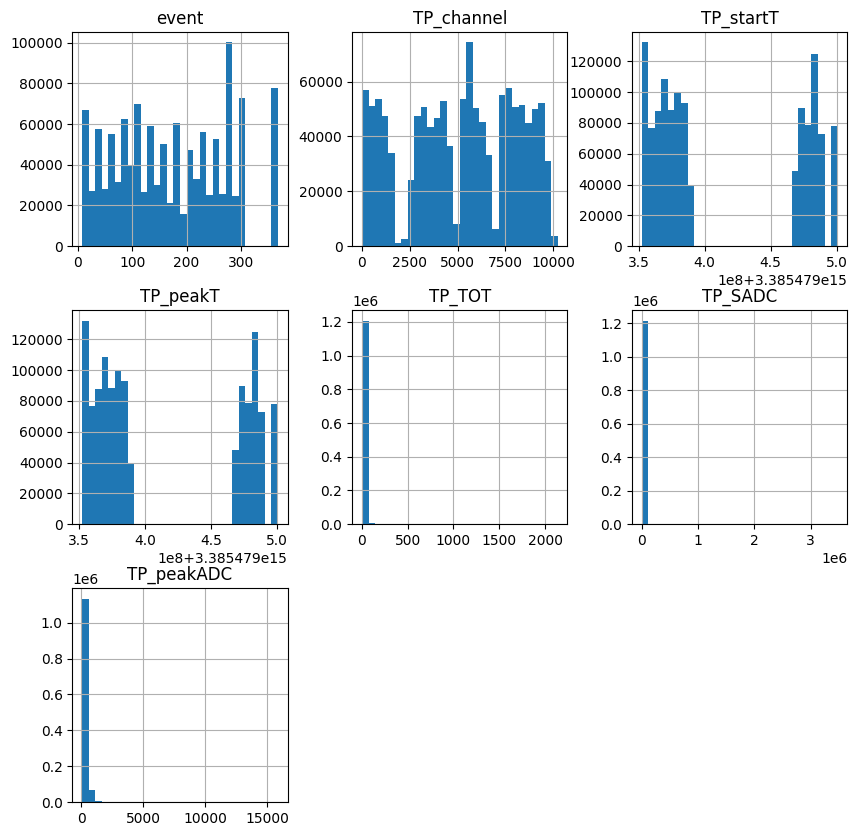

In [57]:
#Let's load the data from run 32974
df = load_data("../data/pdhd_run032974_tps.root", TP_BRANCHES, 1000)
ignore_cols=["subrun", "run", "TP_TPC", "TP_plane", "TP_TPC"]
df_filtered = df.drop(columns=ignore_cols, errors='ignore')
df_filtered[df_filtered.TP_TOT > 2].hist(figsize=(10, 10), bins=30)
plt.show()

In [58]:
#Let's see what event IDs exist in the file
triggers = df.event.unique()
triggers

array([  8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
       112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208,
       216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 360,
       368], dtype=uint32)

## Example event display

### Cosmic signals from the full PDHD detector. 

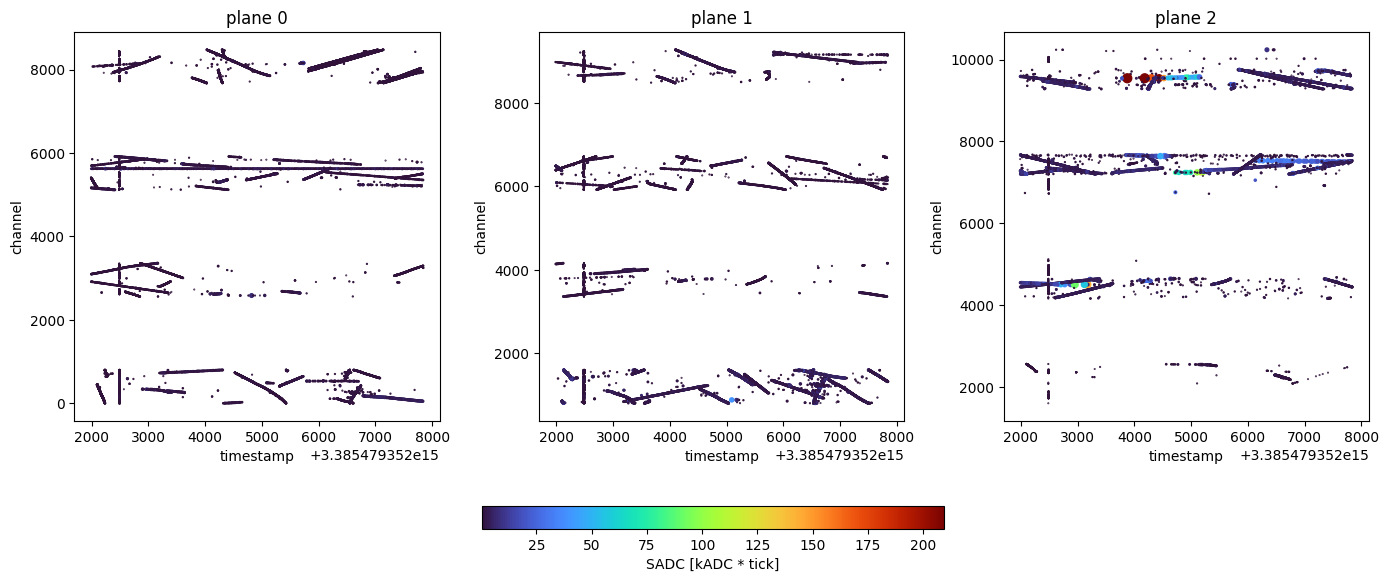

In [59]:

event = triggers[0]
tps_all = df[(df.event == event) & (df.TP_TOT > 1)]
vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_all[tps_all.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")

fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()
